## EDA for Chest X-ray 

#### Import Libraries

In [139]:
import numpy as np
import pandas as pd 
import os
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from skimage.io import imread, imshow

from random import sample 
import scipy
from typing import List
from collections import namedtuple
import re

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
sns.set() 

%matplotlib inline

EDA is the first step to enable you to decide how to look at different ways to slice and dice your data. 

This EDA should also help to inform of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc.

Also, **describe your findings and how will you set up the model training based on the findings.**

####  Load NIH data

In [133]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
48921,00012392_011.png,No Finding,11,12392,50,M,PA,2992,2991,0.143,0.143,NaN
7359,00001946_004.png,Infiltration,4,1946,12,M,AP,2500,2048,0.168,0.168,NaN
91424,00022815_045.png,No Finding,45,22815,9,M,AP,3056,2544,0.139,0.139,NaN


### Shape of the dataset

In [4]:
all_xray_df.shape

(112120, 12)

**All columns in the dataset**

In [5]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

**No of Labels**

In [6]:
no_columns =all_xray_df.columns
for col in no_columns:
    print(col, all_xray_df[col].nunique())
print('total label: ', len(sample_df))

Image Index 112120
Finding Labels 836
Follow-up # 184
Patient ID 30805
Patient Age 107
Patient Gender 2
View Position 2
OriginalImage[Width 904
Height] 1137
OriginalImagePixelSpacing[x 23
y] 23
Unnamed: 11 0
total label:  5606


**Top Finding Labels present**

In [7]:
all_xray_df['Finding Labels'].value_counts().head(10)

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: Finding Labels, dtype: int64

#### standardize the column Labels by replace empty spaces with _

In [8]:
all_xray_df.columns = all_xray_df.columns.str.replace('\.*\s+', '_').str.lower()
all_xray_df.head()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


#### Lets take another look at the column Labels

In [9]:
all_xray_df.columns

Index(['image_index', 'finding_labels', 'follow-up_#', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'originalimage[width',
       'height]', 'originalimagepixelspacing[x', 'y]', 'unnamed:_11'],
      dtype='object')

**Now, lets split the finding sections since some patient have more than one findings present in the diagnosis. Also, encode the labels between 0 and 1 for EDA and for model development**

In [25]:
all_labels = np.unique(list(chain(*all_xray_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head(5)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],unnamed:_11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Check for missing Value before proceeding**

In [26]:
all_xray_df.isna().mean()

image_index                    0.0
finding_labels                 0.0
follow-up_#                    0.0
patient_id                     0.0
patient_age                    0.0
patient_gender                 0.0
view_position                  0.0
originalimage[width            0.0
height]                        0.0
originalimagepixelspacing[x    0.0
y]                             0.0
unnamed:_11                    1.0
Atelectasis                    0.0
Cardiomegaly                   0.0
Consolidation                  0.0
Edema                          0.0
Effusion                       0.0
Emphysema                      0.0
Fibrosis                       0.0
Hernia                         0.0
Infiltration                   0.0
Mass                           0.0
No Finding                     0.0
Nodule                         0.0
Pleural_Thickening             0.0
Pneumonia                      0.0
Pneumothorax                   0.0
dtype: float64

**Since no missing values in our labels, lets, sum the number of each unique Labels**

In [27]:
all_xray_df[all_labels].sum().head(20)

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

### Let's explore patient demographic data such as gender, age, patient position,etc

**Patient gender and view positions are shown below**. 
Notice that there are more male patient than the female patient. Also, the most frenquently view position is PA

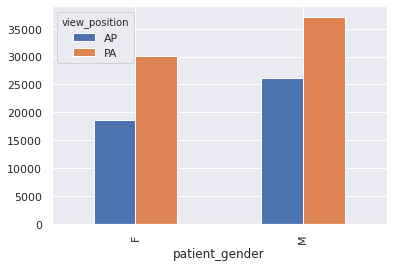

In [30]:
df =all_xray_df.patient_age.groupby([all_xray_df.patient_gender,all_xray_df.view_position])
df.count().unstack().plot(kind='bar')
pass

**Number of male and female**

In [31]:
all_xray_df['patient_gender'].value_counts()

M    63340
F    48780
Name: patient_gender, dtype: int64

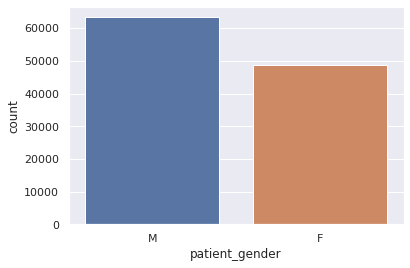

In [32]:
sns.countplot(all_xray_df['patient_gender'])
pass

**view positions**

In [33]:
all_xray_df['view_position'].value_counts()

PA    67310
AP    44810
Name: view_position, dtype: int64

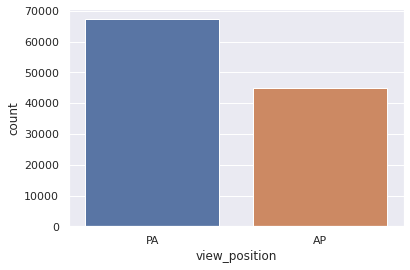

In [34]:
sns.countplot(all_xray_df['view_position'])
pass

## Patients Age Distribution 

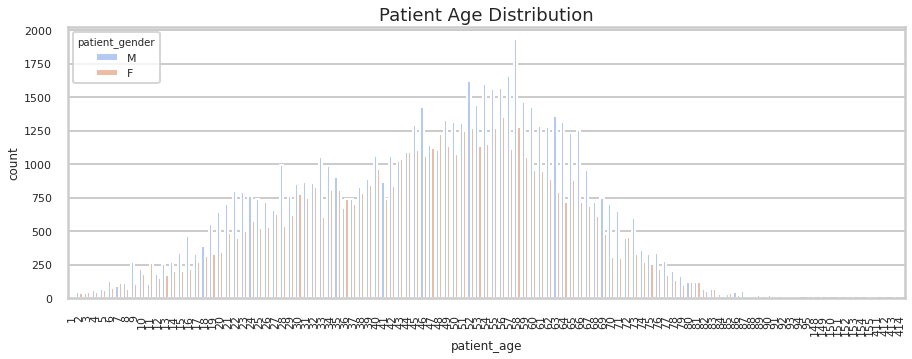

In [35]:
plt.figure(figsize=(15,5))
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
sns.countplot(x='patient_age',hue='patient_gender',data=all_xray_df,palette='coolwarm')
plt.title("Patient Age Distribution",fontsize=18)
degrees = 90
plt.xticks(rotation=degrees)
pass

In [36]:
all_xray_df['patient_age'].value_counts().head(10)

58    3209
56    2916
52    2891
55    2830
57    2771
54    2749
53    2578
51    2556
59    2516
46    2483
Name: patient_age, dtype: int64

**From the age distribution data above, patients of 58 years tops the chart. Notice 414 year of age?, definitely this is an outlier because no human being live for that long, but we are going to keep it in the dataset**

Hence, the age distribution for the performance of our AI is 2 - 88 years but most commonly used for those between 40 - 68 years of Age

#### View position distributions by age

In [42]:
type(all_xray_df)

pandas.core.frame.DataFrame

In [58]:
view_df  = all_xray_df.view_position.groupby(all_xray_df.patient_age).value_counts().unstack()
view_df.head(3)

view_position,AP,PA
patient_age,,
1,14.0,2.0
2,63.0,20.0
3,45.0,39.0


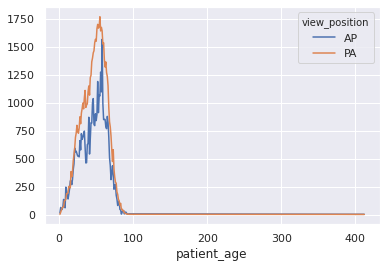

In [59]:
df.plot()
pass

### Number of Pneumonia  Cases

#### Plot all the Unique cases

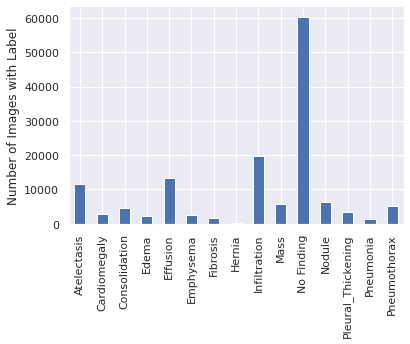

In [60]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
pass

#### Since there are many combinations of potential findings, Let's see 30 most common co-occurrences

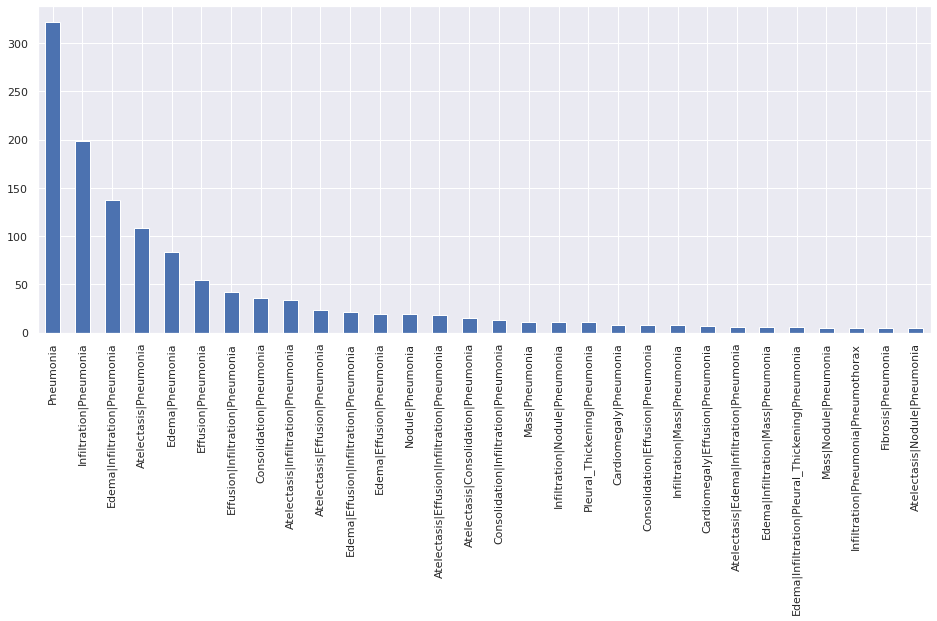

In [64]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['finding_labels'].value_counts()[0:30].plot(kind='bar')
pass

- Looks like Pneumonia  actually occurs alone for the most part, and that its most-common comorbidities are **Infiltration and Atelectasis|Infiltration**

#### Number of cases including:
- pneumonia cases,
- non-pneumonia cases

- **Total number of Pneumonia cases across all sex**

In [65]:
all_xray_df['Pneumonia'].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

- **Total number of Pneumonia cases by sex**

In [66]:
all_xray_df.Pneumonia.groupby(all_xray_df.patient_gender).value_counts().unstack()

Pneumonia,0.0,1.0
patient_gender,,
F,48187,593
M,62502,838


- **Total number of Pneumonia cases by view positions**

In [67]:
all_xray_df.Pneumonia.groupby(all_xray_df.view_position).value_counts().unstack()

Pneumonia,0.0,1.0
view_position,,
AP,44009,801
PA,66680,630


- From the analysis above, there are about 53% of males patients as compared to 47% of female patient.Again, though the number of PA are significantly higher than the number of AP view postion, there are more confirmed cases of pneumonia on AP view position. Hence, the AP view position seem to be more effective in detecting more cases of pneumonia even with fewer numbers 

### Let's see the age distribution of Pneumonia patients 

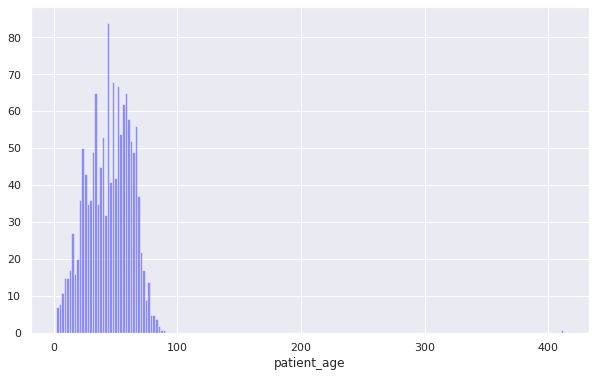

In [111]:
plt.figure(figsize=(10,6))
sns.distplot(all_xray_df[all_xray_df.Pneumonia==1]['patient_age'],color ='blue',kde = False,bins=200)
pass

**Lets filter out ages to 100 or less**

In [119]:
age_dist = all_xray_df[(all_xray_df.Pneumonia == 1) & (all_xray_df.patient_age < 100)]

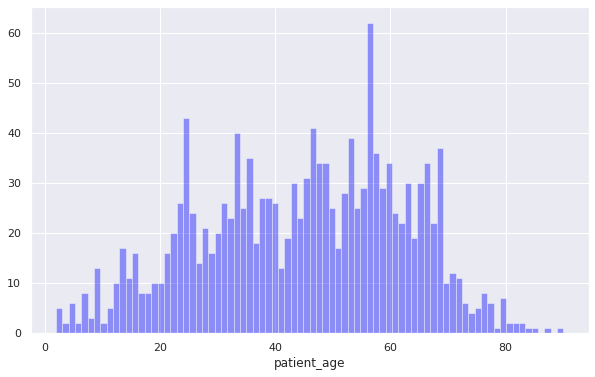

In [127]:
plt.figure(figsize=(10,6))
sns.distplot(age_dist[age_dist.Pneumonia==1]['patient_age'],color ='blue',kde = False,bins=80)
pass

**Let fiter out some reductant age to have a better view of age distribution between male and female patients** 

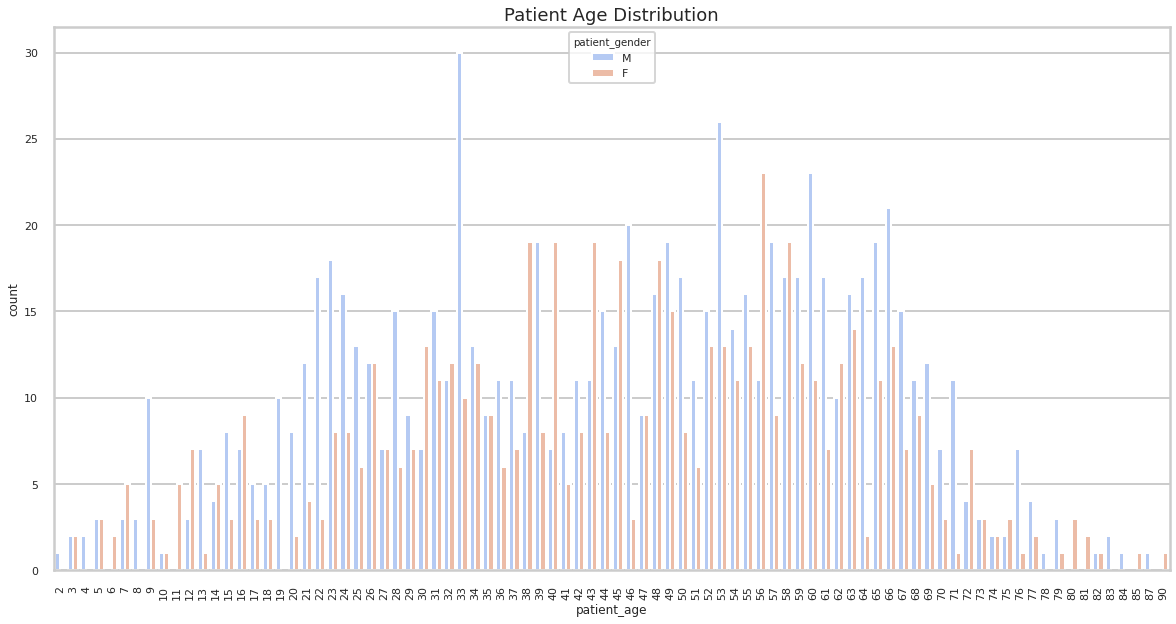

In [131]:
plt.figure(figsize=(20,10))
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
sns.countplot(x='patient_age',hue='patient_gender',data=age_dist,palette='coolwarm')
plt.title("Patient Age Distribution",fontsize=18)
degrees = 90
plt.xticks(rotation=degrees)
pass

#### From the Analysis above, most male patients of 30 years of age and female patients of 56 years of age seem to have mores cases of Pneumonia. Overal, most common age distribution for pneumonia ranges between 21 to 68 years of age

## Pixel-level assessments of the imaging data for healthy, Pneumonia and most common comorbidities patients

**Notice that Patient Age colums has a combination of integer and string, we start by standardizing for easy EDA**

### Load sample dataset

In [144]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4878,00025656_008.png,No Finding,8,25656,063Y,M,AP,3056,2544,0.139,0.139
5019,00026586_001.png,Atelectasis|Mass,1,26586,037Y,M,AP,3056,2544,0.139,0.139
2238,00011504_028.png,No Finding,28,11504,057Y,M,PA,2650,2991,0.143,0.143
1705,00008885_009.png,Atelectasis|Effusion,9,8885,071Y,M,AP,2500,2048,0.168,0.168
1883,00009910_000.png,No Finding,0,9910,041Y,F,AP,2500,2048,0.168,0.168


**Fiter out and separate the integer and string in the age column**

In [146]:
sample_df['patient_age'] = sample_df['Patient Age'].apply(lambda x: re.search(r'\d+', x).group())

In [147]:
sample_df.drop("Patient Age",axis =1, inplace = True)
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,patient_age
5280,00028431_001.png,No Finding,1,28431,F,PA,2544,3056,0.139,0.139,059
1851,00009746_000.png,No Finding,0,9746,M,PA,2048,2500,0.168,0.168,010
2399,00012093_002.png,No Finding,2,12093,M,AP,2500,2048,0.168,0.168,044
1987,00010384_013.png,Pneumothorax,13,10384,F,AP,2048,2500,0.168,0.168,017
3028,00014879_010.png,Fibrosis|Pleural_Thickening,10,14879,M,AP,2500,2048,0.168,0.168,061


### Get the image path

In [149]:
data_sample =sample_df.copy()

In [150]:
data_sample_paths = {os.path.basename(x): x for x       
                     in glob(os.path.join('/data','images*', '*', 
                     '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)

In [151]:
data_sample.sample()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,patient_age,path
3913,00019293_000.png,No Finding,0,19293,F,PA,2586,2509,0.143,0.143,012,/data/images_009/images/00019293_000.png


#### X-ray of Pneumonia Patient

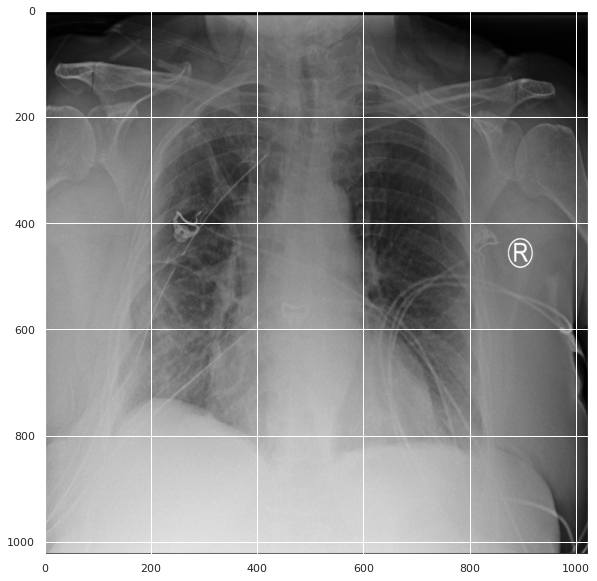

In [152]:
plt.figure(figsize=(15,10))
chest_xray = plt.imread('/data/images_012/images/00028924_005.png')
plt.imshow(chest_xray, cmap='gray')
pass

#### Fill in some coordinates for sections of the image that contain lung, heart, and bone:

In [153]:
lung_x = [640,750]
lung_y = [350,400]

heart_x = [630,650]
heart_y = [650,680]

bone_x = [425,560]
bone_y = [850,900]

#### Plot the image intensities for the subsections for pneumonia patients

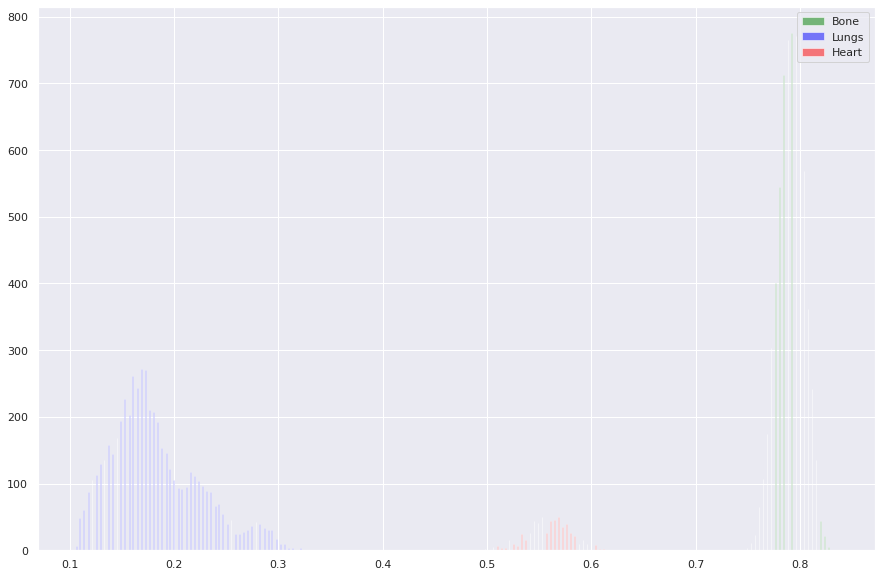

In [154]:
plt.figure(figsize=(15,10))
plt.hist(chest_xray[bone_y[0]:bone_y[1],bone_x[0]:bone_x[1]].ravel(), bins = 256,color='green',alpha=0.5)
plt.hist(chest_xray[lung_y[0]:lung_y[1],lung_x[0]:lung_x[1]].ravel(),bins =256,color='blue',alpha=0.5)
plt.hist(chest_xray[heart_y[0]:heart_y[1],heart_x[0]:heart_x[1]].ravel(),bins=256,color='red',alpha=0.5)
plt.legend(['Bone','Lungs','Heart'])
plt.show()

#### Chest Xray of Healthy

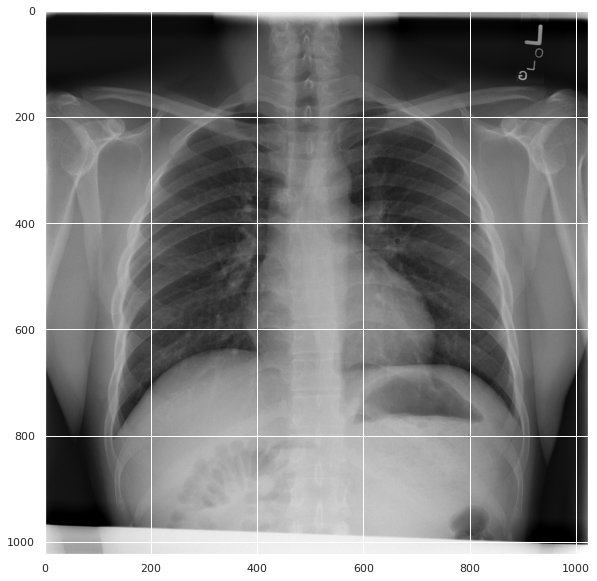

In [155]:
plt.figure(figsize=(15,10))
chest_normal = plt.imread('/data/images_008/images/00017304_000.png')
plt.imshow(chest_normal, cmap='gray')
pass

In [156]:
l_x = [250,350]
l_y = [450,570]

h_x = [600,700]
h_y = [600,650]

b_x = [100,170]
b_y = [250,580]

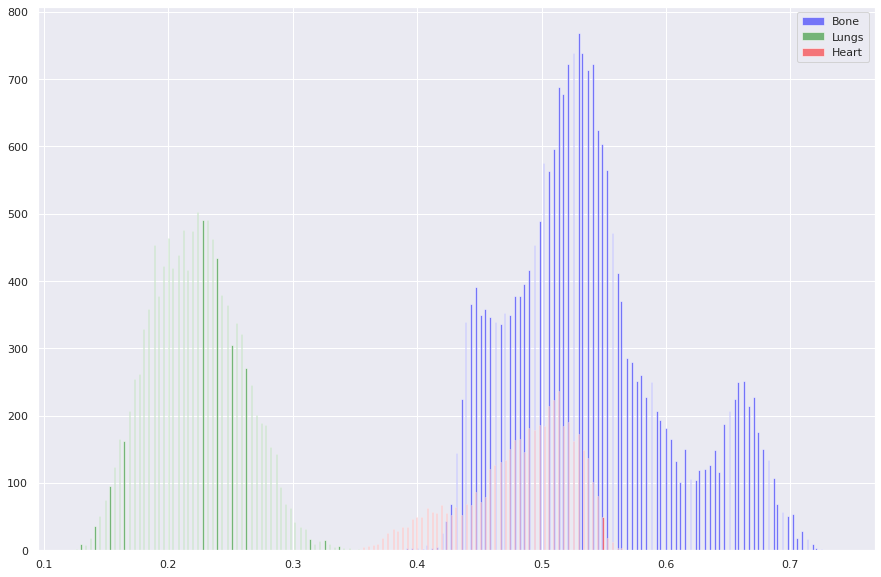

In [157]:
plt.figure(figsize=(15,10))
plt.hist(chest_normal[b_y[0]:b_y[1],b_x[0]:b_x[1]].ravel(), bins = 256,color='blue',alpha=0.5)
plt.hist(chest_normal[l_y[0]:l_y[1],l_x[0]:l_x[1]].ravel(),bins =256,color='green',alpha=0.5)
plt.hist(chest_normal[h_y[0]:h_y[1],h_x[0]:h_x[1]].ravel(),bins=256,color='red',alpha=0.5)
plt.legend(['Bone','Lungs','Heart'])
plt.show()

#### Most common comorbidities patients (Infiltration|Pneumonia)

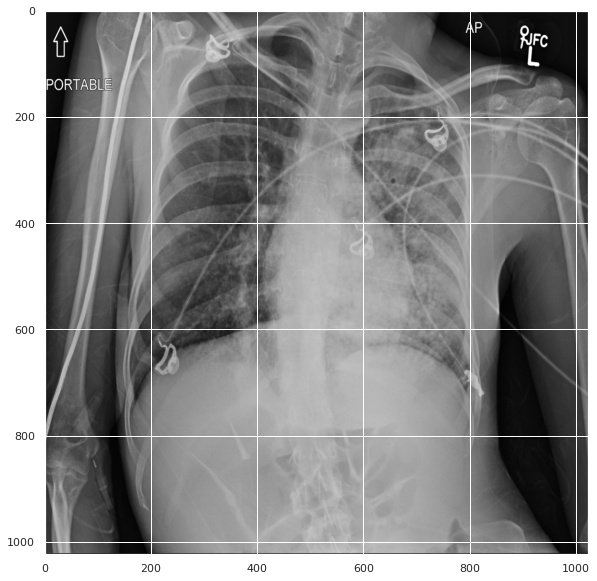

In [173]:
plt.figure(figsize=(15,10))
chest_normal = plt.imread('/data/images_008/images/00016786_001.png')
plt.imshow(chest_normal, cmap='gray')
pass

In [174]:
lp_x = [250,350]
lp_y = [375,385]

hp_x = [620,650]
hp_y = [500,580]

bp_x = [150,200]
bp_y = [180,200]

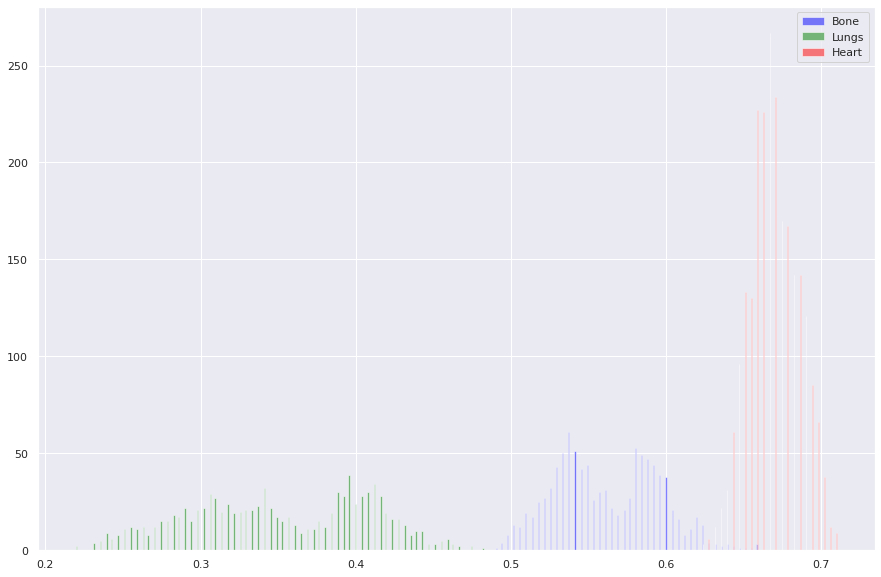

In [175]:
plt.figure(figsize=(15,10))
plt.hist(chest_normal[bp_y[0]:bp_y[1],bp_x[0]:bp_x[1]].ravel(), bins = 256,color='blue',alpha=0.5)
plt.hist(chest_normal[lp_y[0]:lp_y[1],lp_x[0]:lp_x[1]].ravel(),bins =256,color='green',alpha=0.5)
plt.hist(chest_normal[hp_y[0]:hp_y[1],hp_x[0]:hp_x[1]].ravel(),bins=256,color='red',alpha=0.5)
plt.legend(['Bone','Lungs','Heart'])
plt.show()

#### *Notice how the image intensity of the Pneumonia patient differs from the Healthy .Since the bone and heart share similar intensity, it is obvious to see the separations in health which is a good indication for idenfications. Also see how the intensity of patient with pneumonia and patient with filtration|Pneumonia differs. There seem to be high intensity on the for filtration|Pneumonia and high intensity on bone for Patient with PPneumonia* 